# Google Driveをマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

# Setup

In [0]:
import os,re
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import models
from keras.models import Model
from keras import Input
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


%matplotlib inline

Using TensorFlow backend.


In [0]:
log_dir = "drive/My Drive/data/log"
os.makedirs(log_dir, exist_ok=True)

# データ定義

### mnistをロード

In [0]:
(_x_train, _y_train), (_x_test, _y_test) = mnist.load_data()
_x_train, _x_val, _y_train, _y_val = train_test_split(_x_train, _y_train, test_size=0.2)

print("x_train   : ", _x_train.shape)
print("y_train   : ", _y_train.shape)
print("x_val      : ", _x_val.shape)
print("y_val      : ", _y_val.shape)
print("x_test    : ", _x_test.shape)
print("y_test    : ", _y_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
x_train   :  (48000, 28, 28)
y_train   :  (48000,)
x_val      :  (12000, 28, 28)
y_val      :  (12000,)
x_test    :  (10000, 28, 28)
y_test    :  (10000,)


### トレーニングデータの一部を表示

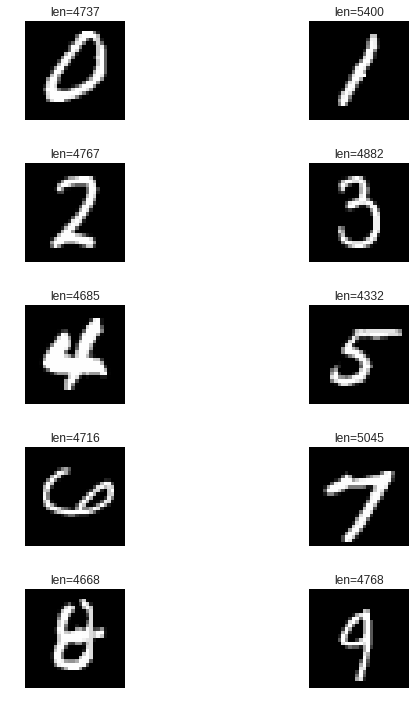

In [0]:
plt.figure(figsize=(10,10))

for i in range(10):
    data = [(x,t) for x, t in zip(_x_train, _y_train) if t == i]  # generator
    x, y = data[0]
    
    plt.subplot(5,2, i+1)
    plt.title("len={}".format(len(data)))
    plt.axis("off")
    plt.imshow(x, cmap='gray')


plt.tight_layout()
plt.show()

# preprocessing

In [0]:
def preprocess(data, label=False):
    if label:
        # one hot encoding
        data = to_categorical(data)
    else:
        # 0-255 -> 0-1
        data = data.astype('float32') / 255
        # (sample, width, height) -> (sample, width, height, channel)
        data = data.reshape((-1, 28, 28, 1))

    return data

In [0]:
x_train = preprocess(_x_train)
x_val= preprocess(_x_val)
x_test = preprocess(_x_test)

y_train = preprocess(_y_train, label=True)
y_val = preprocess(_y_val, label=True)
y_test = preprocess(_y_test, label=True)


print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(x_train.max())
print(x_val.max())
print(y_test.max())

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
1.0
1.0
1.0
(48000, 10)
(12000, 10)
(10000, 10)


# モデルの定義

## Functional API

In [0]:
def model_functional_api():
    activation = 'relu'
    
    input = Input(shape=(28, 28, 1))
    
    x = Conv2D(32, (3,3), padding='same', name='conv1')(input)
    x = Activation(activation, name='act1')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, (3,3), padding='same', name='conv2')(x)
    x = Activation(activation, name='act2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = Conv2D(64, (3,3), padding='same', name='conv3')(x)
    x = Activation(activation, name='act3')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(64, name='dense4')(x)
    x = Activation(activation, name='act4')(x)
    x = Dense(10, name='dense5')(x)
    output = Activation('softmax', name='last_act')(x)
    
    model = Model(input, output)
    
    return model

## Sequential API

In [0]:
def model_sequential():
    activation = 'relu'

    model = models.Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', name='conv1', input_shape=(28, 28 , 1)))
    model.add(Activation(activation, name='act1'))
    model.add(MaxPooling2D((2, 2), name='pool1'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv2'))
    model.add(Activation(activation, name='act2'))
    model.add(MaxPooling2D((2, 2), name='pool2'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
    model.add(Activation(activation, name='act3'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(64, name='dense4'))
    model.add(Activation(activation, name='act4'))
    model.add(Dense(10, name='dense5'))
    model.add(Activation('softmax', name='last_act'))
    
    return model

# model compile

In [0]:
model = model_sequential()
model.summary()
model.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
act2 (Activation)            (None, 14, 14, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 64)          36928     
__________

# Training

In [0]:
ckpt_name = 'weights-{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}-.hdf5'
cbs = [
        TensorBoard(log_dir=log_dir),
        ModelCheckpoint(os.path.join(log_dir, ckpt_name),
                                   monitor='val_acc', verbose=0,
                                   save_best_only=False,
                                   save_weights_only=True,
                                   mode='auto', period=1)
]


datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


batch_size=128
epochs=3
verbose=1
steps_per_epoch = x_train.shape[0] // batch_size


'''
history = model.fit(x_train, y_train,
                                 epochs=epochs, batch_size=batchsize,
                                 validation_data=[x_val, y_val],
                                 callbacks=cbs)
'''

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=steps_per_epoch,
                                                    epochs=epochs,
                                                    validation_data=(x_val, y_val),
                                                    callbacks=cbs,
                                                    verbose=verbose)


Epoch 1/3
375/375 [==============================] - 19s 50ms/step - loss: 0.4151 - acc: 0.8662 - val_loss: 0.0771 - val_acc: 0.9763
Epoch 2/3
375/375 [==============================] - 15s 41ms/step - loss: 0.1207 - acc: 0.9625 - val_loss: 0.0449 - val_acc: 0.9861
Epoch 3/3
375/375 [==============================] - 15s 41ms/step - loss: 0.0835 - acc: 0.9742 - val_loss: 0.0442 - val_acc: 0.9870


# 重みをロードして評価

In [0]:
def key_sort_by_num(x):
    re_list = re.findall(r"[0-9]+", x)
    re_list = list(map(int, re_list))
    return re_list


def list_from_dir(dir, target_ext=None):
    data_list = []
    fnames = os.listdir(dir)
    fnames = sorted(fnames, key=key_sort_by_num)
    for fname in fnames:
        if target_ext is None:
            path = os.path.join(dir, fname)
            data_list.append(path)
        else:
            _, ext = os.path.splitext(fname)
            if ext.lower() in target_ext:
                path = os.path.join(dir, fname)
                data_list.append(path)
    return data_list


def latest_weight(log_dir):
    weight_paths = list_from_dir(log_dir, '.hdf5')
    return weight_paths[-1]


def max_valacc_weight(log_dir):
    weight_paths = list_from_dir(log_dir, '.hdf5')
    max_acc = 0.0
    for i in range(len(weight_paths)):
        split_path = weight_paths[i].split('-')

        epoch = int(split_path[1])
        loss = float(split_path[2])
        acc = float(split_path[3])
        val_loss = float(split_path[4])
        val_acc = float(split_path[5])

        if max_acc < val_acc:
            max_acc = val_acc
            idx = i

    return weight_paths[idx]

In [0]:
print(latest_weight(log_dir))
print(max_valacc_weight(log_dir))

drive/My Drive/data/log/weights-03-0.08-0.98-0.05-0.99-.hdf5
drive/My Drive/data/log/weights-02-0.12-0.96-0.04-0.99-.hdf5


# 評価

In [0]:
model = model_sequential()

ckpt = latest_weight(log_dir)
model.load_weights(ckpt)

model.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])


score = model.evaluate(x_test,  y_test)
print(list(zip(model.metrics_names, score)))

10000/10000 [==============================] - 1s 108us/step
[('loss', 0.038082863802171775), ('acc', 0.9879)]


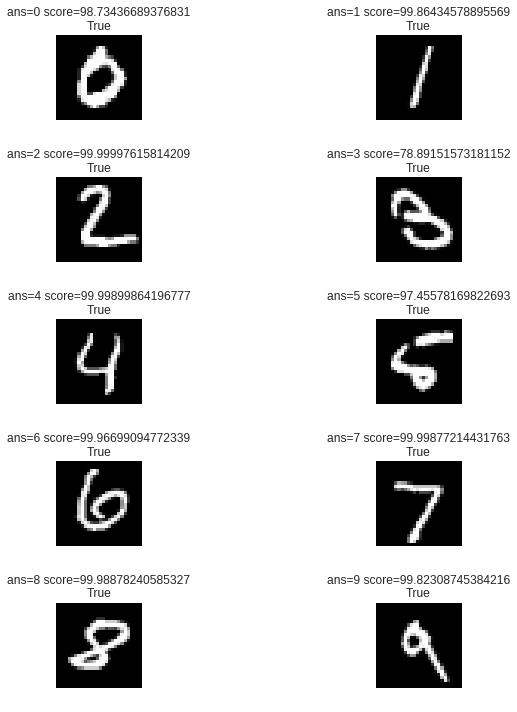

In [0]:
plt.figure(figsize=(10,10))

for i in range(10):
    data = [(x,t) for x, t in zip(_x_test, _y_test) if t == i]
    x, y = data[0]
    
    pred = model.predict(preprocess(x, label=False))
    
    ans = np.argmax(pred)
    score = np.max(pred) * 100
    
    plt.subplot(5,2, i+1)
    plt.axis("off")
    plt.title("ans={} score={}\n{}".format(ans, score,ans==y))

    plt.imshow(x, cmap='gray')


plt.tight_layout()
plt.show()

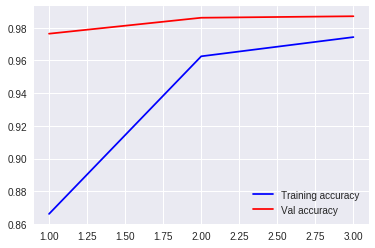

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Val accuracy')

plt.legend()
plt.show()

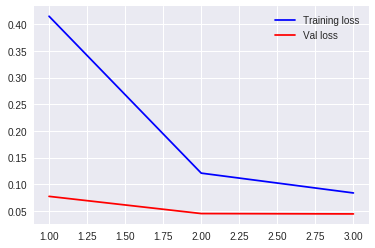

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1 )
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.legend()
plt.show()

# CNNの出力する特徴マップを観察する

In [0]:
ckpt = latest_weight(log_dir)
model.load_weights(ckpt)
model.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

print(model.layers)

[<keras.layers.convolutional.Conv2D object at 0x7f3ef6428da0>, <keras.layers.core.Activation object at 0x7f3ef64284a8>, <keras.layers.pooling.MaxPooling2D object at 0x7f3ef6428828>, <keras.layers.convolutional.Conv2D object at 0x7f3ef64476a0>, <keras.layers.core.Activation object at 0x7f3ef64cc7b8>, <keras.layers.pooling.MaxPooling2D object at 0x7f3eea7f2c50>, <keras.layers.convolutional.Conv2D object at 0x7f3eea7f2c18>, <keras.layers.core.Activation object at 0x7f3eea7d1cf8>, <keras.layers.core.Flatten object at 0x7f3eeb072780>, <keras.layers.core.Dense object at 0x7f3eeb072748>, <keras.layers.core.Activation object at 0x7f3eea775278>, <keras.layers.core.Dense object at 0x7f3eea775438>, <keras.layers.core.Activation object at 0x7f3ee9f151d0>]


## 特徴マップを可視化

In [0]:
def show_imgs(images, row, column, cm=None):
    plt.figure(figsize=(12,12))
    for i in range(row*column):
        plot_num = i+1
    
        plt.subplot(row, column , plot_num)
        plt.axis("off")

        if cm is None:
            plt.imshow(images[:,:,i])
        else:
            plt.imshow(images[:,:,i], cmap=cm)
    
        if plot_num == (row * column):
            break

    plt.tight_layout()
    plt.show()

def get_layer(model, layer_name):
    target_layer = None
    for layer in model.layers:
        if layer.name == layer_name:
            target_layer = layer
    return target_layer

def show_activation_map(model, x, layer_name, row=1, column=1):
    
    target_layer = get_layer(model, layer_name)
    activation_model = models.Model(inputs=model.input, outputs=target_layer.output)
    
    # 入力画像準備
    input = preprocess(x, label=False)

    # マップを出力
    activation = activation_model.predict(input)
    for act in activation:
        print("activation shape : ", act.shape)

    # マップの一部のチャンネルを表示
    show_imgs(activation[0], row=row, column=column, cm='inferno')        


activation shape :  (7, 7, 64)


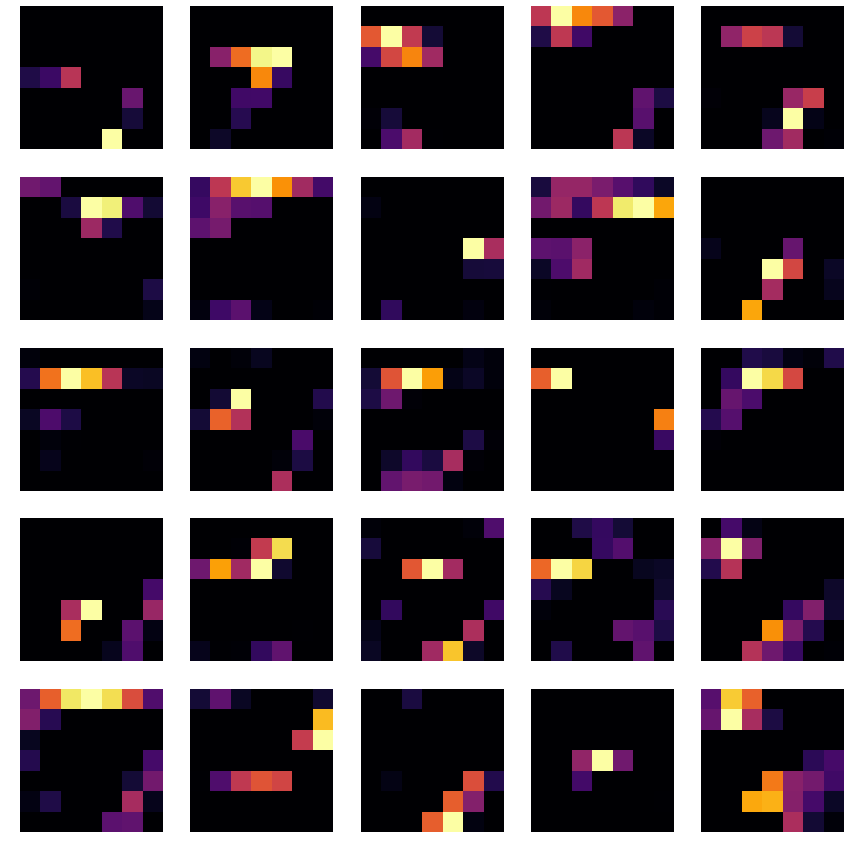

In [0]:
target_layer_name = 'act3'
input_img = _x_test[0]

show_activation_map(model, input_img, target_layer_name, row=5, column=5)

# 重みの可視化

### 重みを画像として表示

In [0]:
def show_weights_as_image(model, layer_name):
    target_layer = get_layer(model, layer_name)
    weights = target_layer.get_weights()
    w, bias= weights
    print("w     shape : ", w.shape)
    print("bias shape : ", bias.shape)
    
    # (width, height, channel, mapnum) -> (channel, width, height, mapnum) 
    w = w.transpose(2,0,1,3)
    
    ch = 0
    show_featuremap(w[ch],
                                    row=5,
                                    column=5,
                                    cm='inferno')

In [0]:
weights = model.get_weights()
for i in range(len(weights)):
    # (width, height, channel, mapnum)
    # 1次元のデータはバイアスのパラメータ
    print("weight_shape[{}] : {}".format(i, weights[i].shape))

weight_shape[0] : (3, 3, 1, 32)
weight_shape[1] : (32,)
weight_shape[2] : (3, 3, 32, 64)
weight_shape[3] : (64,)
weight_shape[4] : (3, 3, 64, 64)
weight_shape[5] : (64,)
weight_shape[6] : (3136, 64)
weight_shape[7] : (64,)
weight_shape[8] : (64, 10)
weight_shape[9] : (10,)


w     shape :  (3, 3, 1, 32)
bias shape :  (32,)


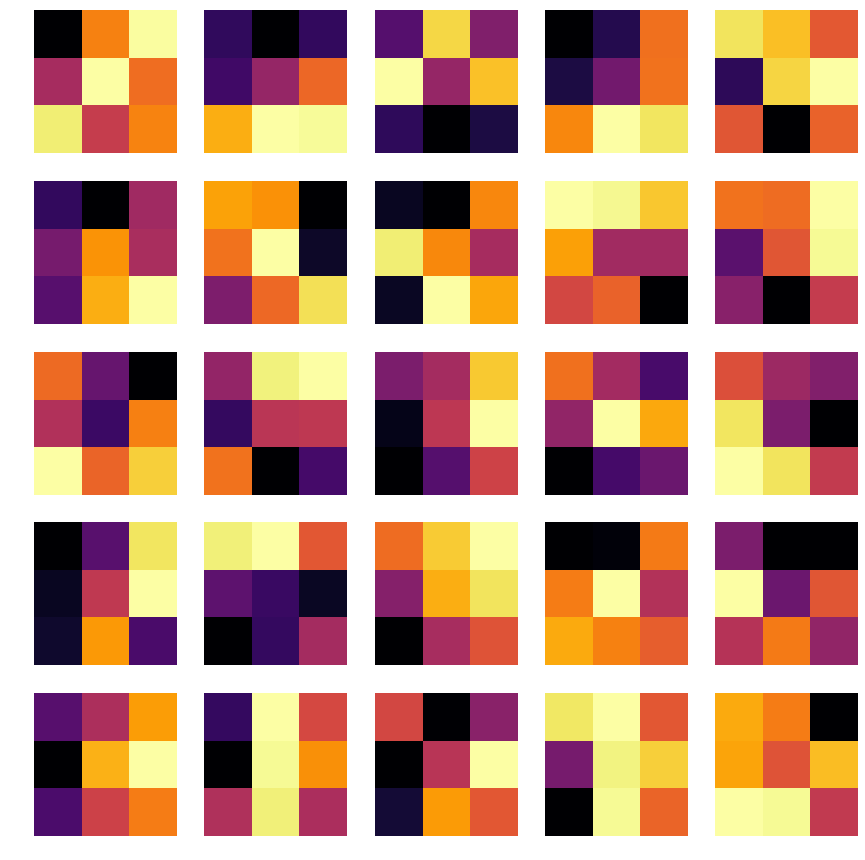

In [0]:
show_weights_as_image(model, 'conv1')

### 重みをヒストグラムとして表示

In [0]:
def show_weights_as_hist(model, layer_name):
    target_layer = get_layer(model, layer_name)
    weights = target_layer.get_weights()
    w, bias= weights
    print("w     shape : ", w.shape)
    print("bias shape : ", bias.shape)
    
    if w.ndim == 4:
        # for conv
        #(width, height, channel, mapnum) -> (channel, width, height, mapnum) 
        #w = w.transpose(2,0,1,3)
        #ch = 0
        #w_flatten = w[ch].flatten()
        w_flatten = w.flatten()
    elif w.ndim == 2:
        # for dense
        w_flatten = w.flatten()
    else:
        raise ValueError("ndim must be 2 or 4 : {}".format(w.ndim))
        
    print(w_flatten.shape)
    

    plt.hist(w_flatten, bins=40)
    plt.show()    
    


w     shape :  (3, 3, 1, 32)
bias shape :  (32,)
(288,)


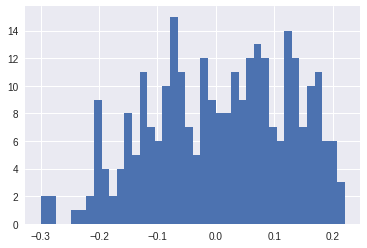

w     shape :  (3, 3, 32, 64)
bias shape :  (64,)
(18432,)


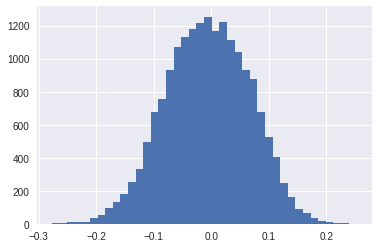

w     shape :  (3, 3, 64, 64)
bias shape :  (64,)
(36864,)


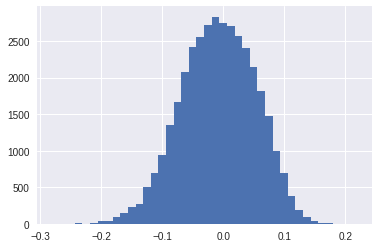

w     shape :  (3136, 64)
bias shape :  (64,)
(200704,)


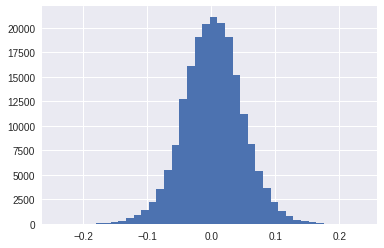

w     shape :  (64, 10)
bias shape :  (10,)
(640,)


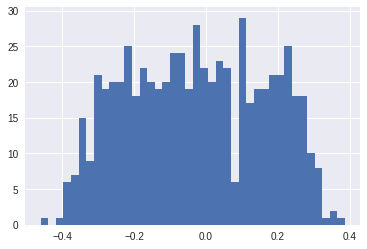

In [0]:
show_weights_as_hist(model, 'conv1')
show_weights_as_hist(model, 'conv2')
show_weights_as_hist(model, 'conv3')
show_weights_as_hist(model, 'dense4')
show_weights_as_hist(model, 'dense5')